In [13]:
import numpy as np
import os
import struct
import matplotlib.pyplot as plt
import imageio


In [14]:
# This is code from the COLMAP git repository, no need to change anything here

def read_array(path):
    with open(path, "rb") as fid:
        width, height, channels = np.genfromtxt(
            fid, delimiter="&", max_rows=1, usecols=(0, 1, 2), dtype=int
        )
        fid.seek(0)
        num_delimiter = 0
        byte = fid.read(1)
        while True:
            if byte == b"&":
                num_delimiter += 1
                if num_delimiter >= 3:
                    break
            byte = fid.read(1)
        array = np.fromfile(fid, np.float32)
    array = array.reshape((width, height, channels), order="F")
    return np.transpose(array, (1, 0, 2)).squeeze()

def write_array(array, path):
    assert array.dtype == np.float32
    if len(array.shape) == 2:
        height, width = array.shape
        channels = 1
    elif len(array.shape) == 3:
        height, width, channels = array.shape
    else:
        assert False

    with open(path, "w") as fid:
        fid.write(str(width) + "&" + str(height) + "&" + str(channels) + "&")

    with open(path, "ab") as fid:
        if len(array.shape) == 2:
            array_trans = np.transpose(array, (1, 0))
        elif len(array.shape) == 3:
            array_trans = np.transpose(array, (1, 0, 2))
        else:
            assert False
        data_1d = array_trans.reshape(-1, order="F")
        data_list = data_1d.tolist()
        endian_character = "<"
        format_char_sequence = "".join(["f"] * len(data_list))
        byte_data = struct.pack(
            endian_character + format_char_sequence, *data_list
        )
        fid.write(byte_data)


In [15]:
frame_number = "07851"

# Set the file paths for the depth and normal maps
file_name = f"eastbound_20240319_{frame_number}.png.geometric.bin"
# file_name = 'eastbound_20240319_08026.png.geometric.bin'

def get_depth_normal_map_paths(file_name):
    depth_map_path = 'dense2/stereo/depth_maps/eastbound/' + file_name  # Change this to your actual file path
    normal_map_path = 'dense2/stereo/normal_maps/eastbound/' + file_name  # Change this to your actual file path
    return depth_map_path, normal_map_path

depth_map_path, normal_map_path = get_depth_normal_map_paths(file_name)

# Check if files exist
if not os.path.exists(depth_map_path):
    raise FileNotFoundError(f"File not found: {depth_map_path}")

if not os.path.exists(normal_map_path):
    raise FileNotFoundError(f"File not found: {normal_map_path}")

# Read depth and normal maps
depth_map = read_array(depth_map_path)
normal_map = read_array(normal_map_path)

# Set the visualization parameters
min_depth_percentile = 5
max_depth_percentile = 95


In [16]:
# Todo: kinda obsolote but in theory this is the way to remove the outliers

# Set the visualization parameters
min_depth_percentile = 5
max_depth_percentile = 95

# Process the depth map based on percentiles
min_depth, max_depth = np.percentile(depth_map, [min_depth_percentile, max_depth_percentile])
print(f"min_depth: {min_depth}, max_depth: {max_depth}")
depth_map[depth_map < min_depth] = min_depth
depth_map[depth_map > max_depth] = max_depth


min_depth: 0.0, max_depth: 26.18873891830441


In [17]:
depth_map.shape

(1348, 2400)

In [18]:
import cv2

# Load the original 2D image and the depth map
original_image = cv2.imread('eastbound_20240319_07851.png')

original_image.shape

(1520, 2704, 3)

In [19]:
1348/2400

0.5616666666666666

In [20]:
1520/2704

0.5621301775147929

In [21]:
# Aspect ratio's are different but after resizing images overlap nicely

(1348/2400) / (1520/2704)

0.9991754385964913

In [22]:
# Resize the depth map to match the dimensions of the original image
# depth_map_resized = cv2.resize(depth_map, (original_image.shape[1], original_image.shape[0]))
depth_map_resized = cv2.resize(depth_map, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

depth_map = depth_map_resized

# Remove values that are too far from the camera and also set 0 values to NaN
# Replace zeros with NaNs for better visualization
depth_map[depth_map == 0] = np.nan
depth_map[depth_map > 5] = np.nan

C:\Users\lenov\AppData\Local\Temp\ipykernel_32384\2479737659.py:6: RuntimeWarning: invalid value encountered in cast
  depth_map_normalized = depth_map_normalized.astype(np.uint8)


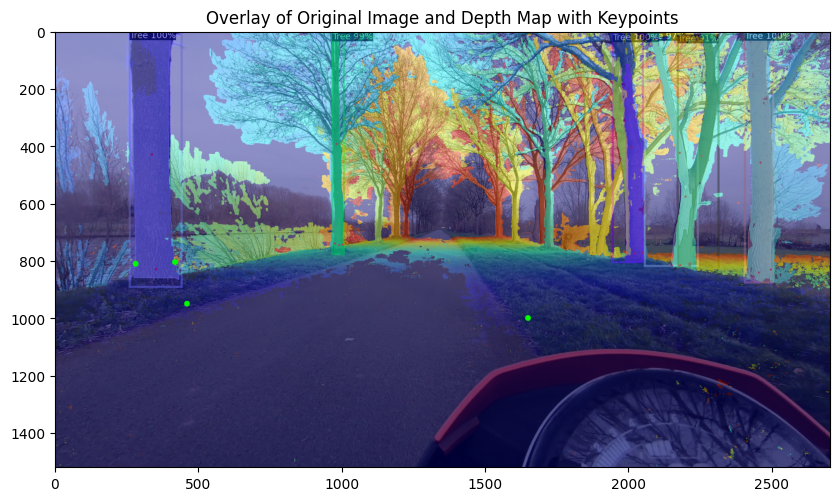

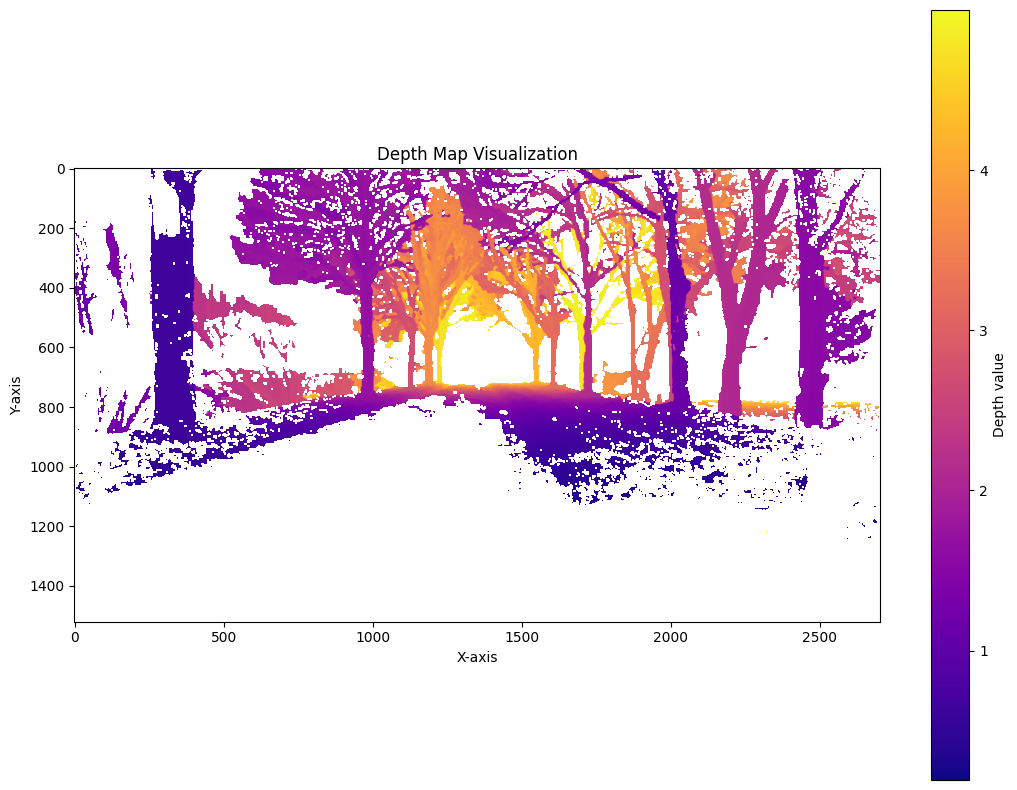

Mean Depth: 2.0029561519622803
Median Depth: 1.7506359815597534
Standard Deviation of Depth: 1.176411747932434


In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Normalize the depth map for visualization (optional)
depth_map_normalized = cv2.normalize(depth_map_resized, None, 0, 255, cv2.NORM_MINMAX)
depth_map_normalized = depth_map_normalized.astype(np.uint8)

# Convert depth map to a color map
depth_map_colored = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_JET)

# Overlay the depth map onto the original image
overlay = cv2.addWeighted(original_image, 0.6, depth_map_colored, 0.4, 0)

# Define keypoints (example coordinates)
left_point = (281, 811)
right_point = (418, 805)

# Points manually selected to estimate road width
road_left = (1650,1000)
road_right = (460,950)
keypoints = [
    left_point,
    right_point,
    road_left,
    road_right
]

# Add keypoints to the overlay image
for point in keypoints:
    cv2.circle(overlay, point, 10, (0, 255, 0), -1)

# Convert BGR image to RGB for displaying with matplotlib
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# Display the overlay image with keypoints
plt.figure(figsize=(10, 10))
plt.imshow(overlay_rgb)
plt.title('Overlay of Original Image and Depth Map with Keypoints')
# plt.axis('off')
plt.show()

# Visualize the depth map
plt.figure(figsize=(13, 10))
plt.imshow(depth_map, cmap='plasma')
plt.colorbar(label='Depth value')
plt.title("Depth Map Visualization")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

# Compute basic statistics ignoring NaNs
mean_depth = np.nanmean(depth_map)
median_depth = np.nanmedian(depth_map)
std_depth = np.nanstd(depth_map)

print(f'Mean Depth: {mean_depth}')
print(f'Median Depth: {median_depth}')
print(f'Standard Deviation of Depth: {std_depth}')

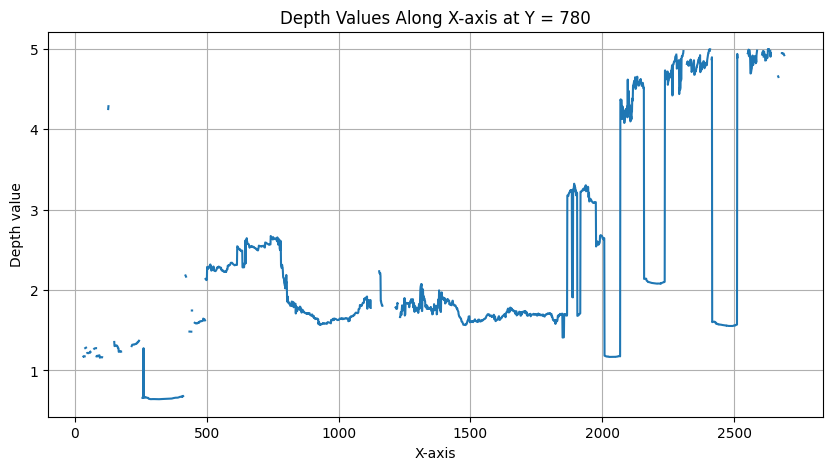

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Extract depth values along the x-axis for y = 600
y_value = 780
depth_values = depth_map[y_value, :]

# Plot the depth values
plt.figure(figsize=(10, 5))
plt.plot(depth_values)
plt.xlabel('X-axis')
plt.ylabel('Depth value')
plt.title(f'Depth Values Along X-axis at Y = {y_value}')
plt.grid(True)
plt.show()


In [25]:
depth_value = depth_map[780, 2480]
print(depth_value*100)

155.31476736068726


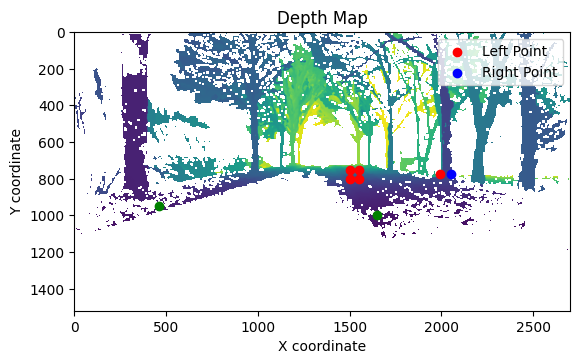

2.6749046 1.1712319 1.1709608
[1.17182466 0.02193744 2.57158581] [0.55859119 0.00960329 1.15072208]
[0.61323347 0.01233415 1.42086373]
The width of the tree trunk is: 1.5475985143304716 units
1.5475985143304716
The width of the tree trunk is: 1.5475985143304716 units
The distance to the midpoint from the left point is: 1.5566508503915817 units
The distance to the midpoint from the right point is: 0.023085484607937714 units


In [26]:
import numpy as np
import cv2

def compute_3d_coordinates_simple_radial(x, y, depth, fx, cx, cy, k1):
    # Assuming distortion is negligible for simplicity.
    X = (x - cx) * depth / fx
    Y = (y - cy) * depth / fx
    Z = depth
    """
    Convert pixel coordinates to world coordinates using the depth value and camera intrinsics.
    """
    X = (x - cx) * depth / fx
    Y = (y - cy) * depth / fx
    Z = depth / (1 + k1 * depth)
    # return X, Y, Z
    return np.array([X, Y, Z])

def compute_tree_trunk_width(left_point, right_point, depth_map, fx, cx, cy, k1, depthm_override=False, d1=None, d2=None):
    x1, y1 = left_point
    x2, y2 = right_point
    
    mid_point = ((x1 + x2) // 2, (y1 + y2) // 2)
    xm = mid_point[0]
    ym = mid_point[1]
    
    depth1 = depth_map[y1, x1]
    depth2 = depth_map[y2, x2]
    depthm = depth_map[ym, xm]
    print(depth1, depthm, depth2)
    if depthm_override:
        if d1 is not None:
            depth1 = d1
        else:
            depth1 = depthm
        if d2 is not None:
            depth2 = d2
        else:
            depth2 = depthm        
        print(depth1, depthm, depth2)
    # depthm = depth_map[700,1650]
    # print(depth1, depth2, depthm)
    
    point1_3d = compute_3d_coordinates_simple_radial(x1, y1, depth1, fx, cx, cy, k1)
    point2_3d = compute_3d_coordinates_simple_radial(x2, y2, depth2, fx, cx, cy, k1)
    
    print(point1_3d, point2_3d)
    print(point1_3d - point2_3d)
    
    width = np.linalg.norm(point1_3d - point2_3d)
    return width

# Example usage
# depth_map_path = 'eastbound_20240319_07851_depth.png'
# depth_map = cv2.imread(depth_map_path, cv2.IMREAD_UNCHANGED)

# Resize the depth map to match the input image size
# input_image_size = (2704, 1520)
# depth_map = cv2.resize(depth_map, input_image_size, interpolation=cv2.INTER_NEAREST)

import matplotlib.pyplot as plt

plt.imshow(depth_map)
plt.title('Depth Map')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
# plt.show()



# print(depth_map.size)

# Camera intrinsics
fx = 1463.2
cx = 1352
cy = 760
k1 = 0.01502


# Camera intrinsics
# fx = 1414.85966
# fy = 1427.46183
# cx = 1332.70149
# cy = 799.437498
# k1 = 0.01502

#  [
#     281.7899475097656,
#     811.9313354492188,
#     4.433836460113525
# ],
# [
#     418.49737548828125,
#     805.848388671875,
#     0.8606317043304443
# ],

#  [
#     2415.640625,
#     831.8865356445312,
#     1.151667833328247
# ],
# [
#     2497.210205078125,
#     831.8865356445312,
#     0.8899378180503845
# ],


# [
#     1993.714111328125,
#     772.6473999023438,
#     0.6860290765762329
# ],
# [
#     2050.280029296875,
#     772.6473999023438,
#     0.6126059889793396
# ],


left_point = (281, 811)
right_point = (418, 805)

# left_point = (281, 811)
# right_point = (415, 805)

left_point = (2415, 831)
right_point = (2497, 831)
left_point = (1993, 772)
# left_point = (2010, 773)
right_point = (2050, 772)

plt.scatter(*left_point, color='red', label='Left Point')  # Scatter plot for left point
plt.scatter(*right_point, color='blue', label='Right Point')  # Scatter plot for right point
plt.scatter(1650,1000, color='green')  # Scatter plot for right point
plt.scatter(460,950, color='green')  # Scatter plot for right point

plt.scatter(1550,800, color='red')  # Scatter plot for right point
plt.scatter(1500,800, color='red')  # Scatter plot for right point
plt.scatter(1550,750, color='red')  # Scatter plot for right point
plt.scatter(1500,750, color='red')  # Scatter plot for right point

# Adding a legend to identify the points
plt.legend()

plt.show()



width = compute_tree_trunk_width(left_point, right_point, depth_map, fx, cx, cy, k1)
print(f"The width of the tree trunk is: {width} units")


# Function to compute the distance between two 3D points
def compute_distance(point1, point2):
    return np.linalg.norm(point1 - point2)


# Compute the midpoint
mid_point = ((left_point[0] + right_point[0]) // 2, (left_point[1] + right_point[1]) // 2)

# Get depth values
depth_left = depth_map[left_point[1], left_point[0]]
depth_right = depth_map[right_point[1], right_point[0]]
depth_mid = depth_map[mid_point[1], mid_point[0]]

# Compute 3D coordinates
point3d_left = compute_3d_coordinates_simple_radial(left_point[0], left_point[1], depth_left, fx, cx, cy, k1)
point3d_right = compute_3d_coordinates_simple_radial(right_point[0], right_point[1], depth_right, fx, cx, cy, k1)
point3d_mid = compute_3d_coordinates_simple_radial(mid_point[0], mid_point[1], depth_mid, fx, cx, cy, k1)

# Compute distances
width = compute_distance(point3d_left, point3d_right)
distance_to_mid = compute_distance(point3d_left, point3d_mid)

road_left = (1650,1000)
road_right = (460,950)

distance_roads = compute_distance(point3d_left, point3d_right)
print(distance_roads)

print(f"The width of the tree trunk is: {width} units")
print(f"The distance to the midpoint from the left point is: {distance_to_mid} units")
print(f"The distance to the midpoint from the right point is: {compute_distance(point3d_right, point3d_mid)} units")



0.58804935 nan 0.49559462
[-0.35848826  0.07635961  0.58290088] [0.10093439 0.08128944 0.49193276]
[-0.45942265 -0.00492983  0.09096812]
The width of the tree trunk is: 1.5475985143304716 units
1500 1550 800
[1.3638948 1.3693665 1.3696276 1.3718983 1.3718983 1.3741765 1.3501014
 1.3412241 1.3487484 1.3317344 1.3211452 1.3277951 1.3291718 1.3291718
 1.3229436 1.3167733 1.3101391 1.320817  1.3243062 1.3163905 1.3217025
 1.3254541 1.3254541 1.3220491 1.3198632 1.3176845 1.3149408 1.3040254
 1.3091918 1.3143991 1.3143991 1.3217444 1.3217317 1.321719  1.3376076
 1.3343303 1.3310689 1.319796  1.3199427 1.3199427 1.3200895 1.3179331
 1.3197185 1.3059349 1.307709  1.3112383 1.3066264 1.3127173 1.3127173
 1.321525 ]


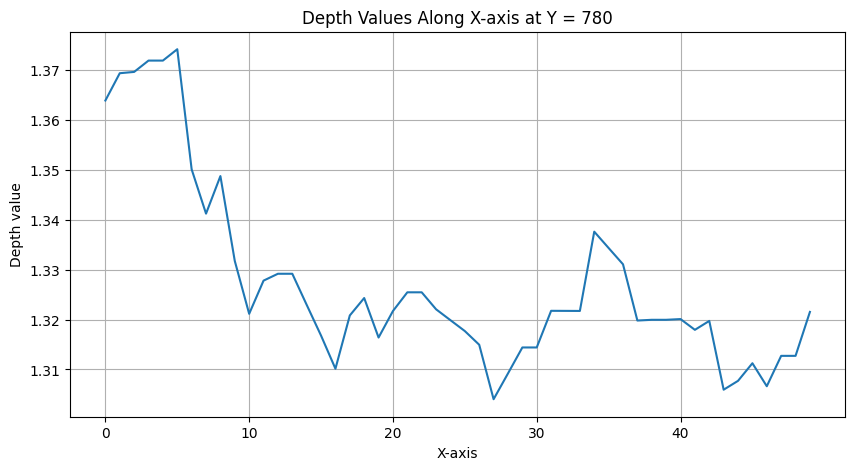

1.3638948 1.3176845 1.3277427
[0.13795546 0.03728526 1.33651537] [0.17966994 0.03629696 1.30178166]
[-0.04171448  0.0009883   0.03473371]
The width of the tree trunk is: 0.054290925126944924 units
The width of the tree trunk is: 46.366031925286556 centimeters
1500 1550 750


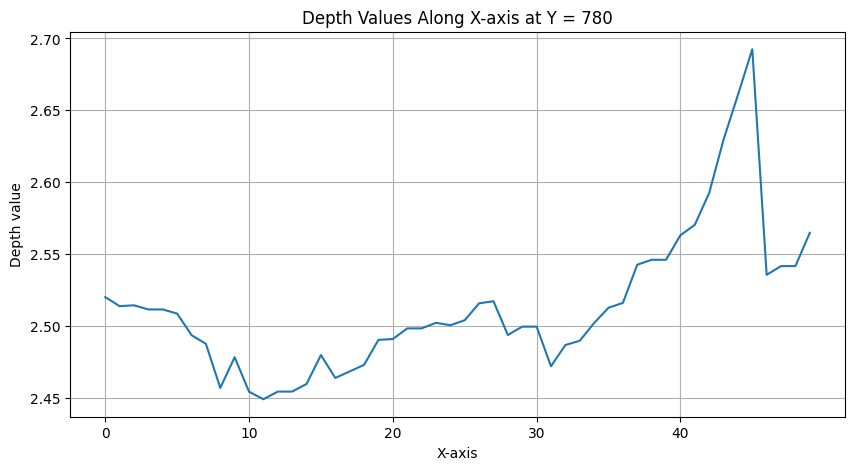

2.5200508 2.5039635 2.525763
[ 0.25489852 -0.01722287  2.42814274] [ 0.34178587 -0.01726191  2.43344551]
[-8.68873481e-02  3.90395758e-05 -5.30276925e-03]
The width of the tree trunk is: 0.08704902155691381 units
The width of the tree trunk is: 74.34240074442336 centimeters
1998 2050 773


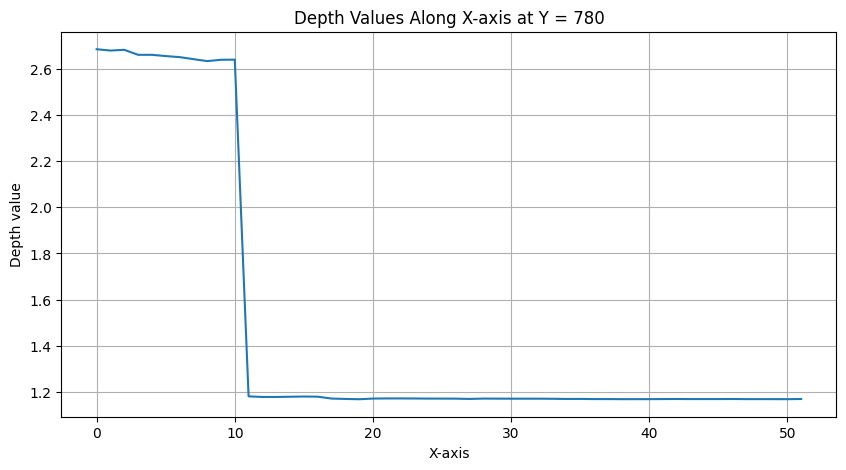

2.6837533 1.1715454 1.1707792
[1.18487193 0.02384417 2.57976307] [0.55850458 0.01040195 1.15054674]
[0.62636735 0.01344222 1.42921633]
The width of the tree trunk is: 1.5605050628930621 units
The width of the tree trunk is: 1332.7167919222115 centimeters
2.6837533 1.1715454 1.1707792
1.1715454 1.1715454 1.1715454
[0.51723505 0.01040875 1.15128664] [0.55887007 0.01040875 1.15128664]
[-0.04163502  0.          0.        ]
The width of the tree trunk is: 0.04163501919652013 units
The width of the tree trunk is: 35.55751950739325 centimeters
2415 2497 831


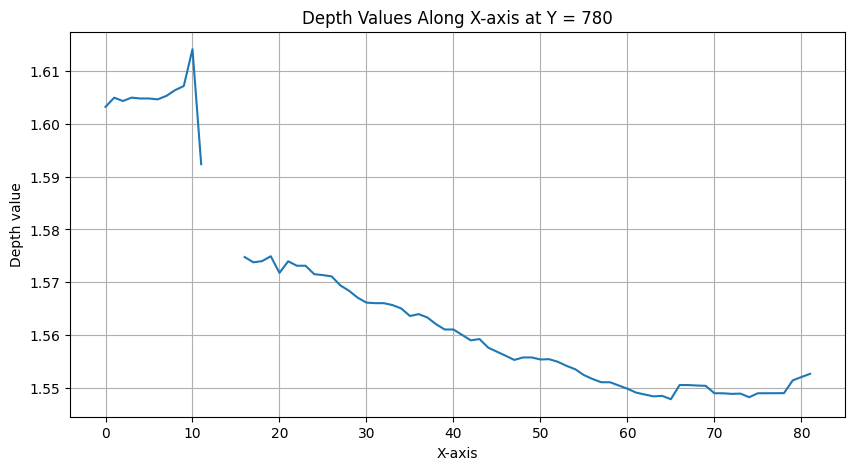

1.6032284 1.5600076 1.5524857
[1.16472925 0.07779471 1.56552972] [1.21486887 0.07533248 1.51710924]
[-0.05013962  0.00246223  0.04842048]
The width of the tree trunk is: 0.06974659139923346 units
The width of the tree trunk is: 59.56562125134581 centimeters
1.6032284 1.5600076 1.5524857
1.5600076 1.5600076 1.5600076
[1.13332972 0.07569747 1.52429142] [1.22075497 0.07569747 1.52429142]
[-0.08742525  0.          0.        ]
The width of the tree trunk is: 0.08742524666366447 units
The width of the tree trunk is: 74.66370794760523 centimeters
281 418 811


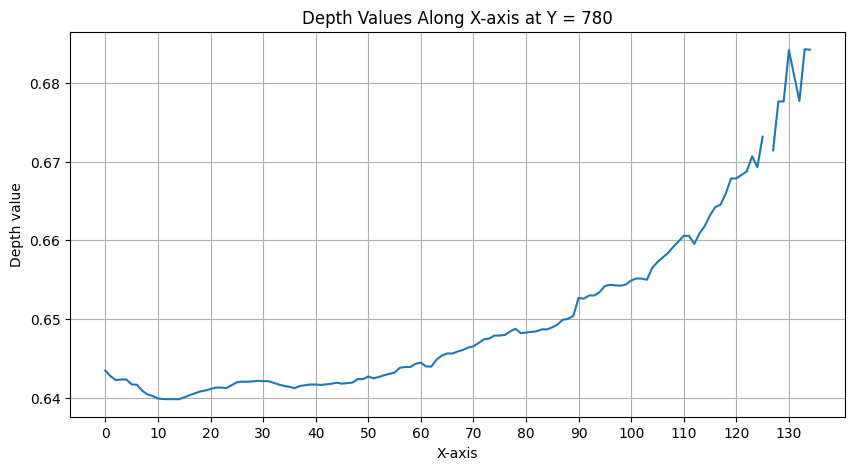

0.64343643 0.64606327 1.4853189
[-0.47096803  0.02242705  0.63727752] [-0.94811909  0.05177096  1.45290532]
[ 0.47715106 -0.02934391 -0.81562781]
The width of the tree trunk is: 0.9454009293028157 units
The width of the tree trunk is: 807.3999396354843 centimeters
0.64343643 0.64606327 1.4853189
0.64606327 0.64606327 0.64606327
[-0.47289076  0.02251861  0.63985421] [-0.4123996   0.02251861  0.63985421]
[-0.06049116  0.          0.        ]
The width of the tree trunk is: 0.06049116166026425 units
The width of the tree trunk is: 51.66121458014121 centimeters
0.64343643 0.64606327 1.4853189
0.64343643 0.64606327 0.69343643
[-0.47096803  0.02242705  0.63727752] [-0.44263916  0.0241698   0.68628845]
[-0.02832886 -0.00174276 -0.04901094]
The width of the tree trunk is: 0.05663597270302633 units
The width of the tree trunk is: 48.368770882573955 centimeters


In [27]:
def extract_depth_along_line(depth_map, left_point, right_point, wider=0):
    x1, y = left_point
    x2, _ = right_point
    
    if wider >0:
        x1 = x1 - wider
        x2 = x2 + wider
    
    print(x1, x2, y)
    
    depth_values = depth_map[y, x1:x2]
    return depth_values
    # depth_points = [(x, y, depth_map[y, x]) for x in range(x1, x2 + 1) if not np.isnan(depth_map[y, x])]
    # return depth_points

def plot_points(depth_values, y_value=780, x_start=0):
    # Number of depth values
    num_points = len(depth_values)
    
    # Create the x-values starting from x_start
    x_values = np.arange(0, num_points)
    
    # Create the x-tick labels from 0 to num_points-1
    x_tick_labels = np.arange(x_start, x_start + num_points)

    # Plot the depth values
    plt.figure(figsize=(10, 5))
    plt.plot(depth_values)
    plt.xlabel('X-axis')
    plt.ylabel('Depth value')
    plt.title(f'Depth Values Along X-axis at Y = {y_value}')
            
    # Set the x-tick labels
    plt.xticks(ticks=x_values[::10], labels=x_tick_labels[::10])  # Adjust the step size as needed
    
    plt.grid(True)
    plt.show()

right_point = (1650,1000)
left_point = (460,950)
# right_point = (1550,750 )
# left_point = (1500,750 )
road_width = compute_tree_trunk_width(left_point, right_point, depth_map, fx, cx, cy, k1, depthm_override=False)
print(f"The width of the tree trunk is: {width} units")
units_per_meter = road_width / 4

right_point = (1550,800)
left_point = (1500,800 )
depth_values = extract_depth_along_line(depth_map, left_point, right_point)
print(depth_values)
plot_points(depth_values)
width = compute_tree_trunk_width(left_point, right_point, depth_map, fx, cx, cy, k1)
print(f"The width of the tree trunk is: {width} units")
print(f"The width of the tree trunk is: {(width/units_per_meter)*100} centimeters")
right_point = (1550,750 )
left_point = (1500,750 )
depth_values = extract_depth_along_line(depth_map, left_point, right_point)
plot_points(depth_values)
width = compute_tree_trunk_width(left_point, right_point, depth_map, fx, cx, cy, k1)
print(f"The width of the tree trunk is: {width} units")
print(f"The width of the tree trunk is: {(width/units_per_meter)*100} centimeters")



left_point = (1998, 773)
right_point = (2050, 773)
depth_values = extract_depth_along_line(depth_map, left_point, right_point)
plot_points(depth_values)
width = compute_tree_trunk_width(left_point, right_point, depth_map, fx, cx, cy, k1)
print(f"The width of the tree trunk is: {width} units")
print(f"The width of the tree trunk is: {(width/units_per_meter)*100} centimeters")
width = compute_tree_trunk_width(left_point, right_point, depth_map, fx, cx, cy, k1, True)
print(f"The width of the tree trunk is: {width} units")
print(f"The width of the tree trunk is: {(width/units_per_meter)*100} centimeters")


left_point = (2415, 831)
right_point = (2497, 831)
depth_values = extract_depth_along_line(depth_map, left_point, right_point)
plot_points(depth_values)
width = compute_tree_trunk_width(left_point, right_point, depth_map, fx, cx, cy, k1)
print(f"The width of the tree trunk is: {width} units")
print(f"The width of the tree trunk is: {(width/units_per_meter)*100} centimeters")
width = compute_tree_trunk_width(left_point, right_point, depth_map, fx, cx, cy, k1, True)
print(f"The width of the tree trunk is: {width} units")
print(f"The width of the tree trunk is: {(width/units_per_meter)*100} centimeters")




left_point = (281, 811)
right_point = (418, 811)
depth_values = extract_depth_along_line(depth_map, left_point, right_point)
plot_points(depth_values)
width = compute_tree_trunk_width(left_point, right_point, depth_map, fx, cx, cy, k1)
print(f"The width of the tree trunk is: {width} units")
print(f"The width of the tree trunk is: {(width/units_per_meter)*100} centimeters")

left_point = (281, 811)
right_point = (418, 811)
width = compute_tree_trunk_width(left_point, right_point, depth_map, fx, cx, cy, k1, True)
print(f"The width of the tree trunk is: {width} units")
print(f"The width of the tree trunk is: {(width/units_per_meter)*100} centimeters")
left_point = (281, 811)
right_point = (418, 811)
width = compute_tree_trunk_width(left_point, right_point, depth_map, fx, cx, cy, k1, True,0.64343643, 0.69343643)
print(f"The width of the tree trunk is: {width} units")
print(f"The width of the tree trunk is: {(width/units_per_meter)*100} centimeters")

In [28]:
start = 8236
for i in range(20):    
    print(f"\"0{start}\",")
    start+=5

"08236",
"08241",
"08246",
"08251",
"08256",
"08261",
"08266",
"08271",
"08276",
"08281",
"08286",
"08291",
"08296",
"08301",
"08306",
"08311",
"08316",
"08321",
"08326",
"08331",


In [29]:
# C:\Users\lenov\Documents\School\2023\Computer_Visie\colmap_test\dense2\stereo\depth_maps\eastbound

from glob import glob

output_dir = './assets/annotated_05/eastbound'
depth_map_folder = 'dense2/stereo/depth_maps/eastbound/'
depth_dir_pattern = depth_map_folder + "/*.png.geometric.bin"

depth_paths = glob(depth_dir_pattern)
depth_paths.sort()

# json_paths.append("../eastbound_20240319_07851.json")
frame_numbers = []

for i in range(len(depth_paths)):
    dotsplit = depth_paths[i].split('.')
    frame_number = dotsplit[0].split('_')[-1]
    print(frame_number)
    frame_numbers.append(frame_number)

print(frame_numbers)

07816
07821
07826
07831
07836
07841
07846
07851
07856
07861
07866
07871
07876
07881
07886
07891
07896
07901
07906
07911
07916
07921
07926
07931
07936
07941
07946
07951
07956
07961
07966
07971
07976
07981
07986
07991
07996
08001
08006
08011
08016
08021
08026
08031
08036
08041
08046
08051
08056
08061
08066
08071
08076
08081
08086
08091
08096
08101
08106
08111
08116
08121
08126
08131
08136
08141
08146
08151
08156
08161
08166
08171
08176
08181
08186
08191
08196
08201
08206
08211
08216
08221
08226
08231
08236
08241
08246
08251
08256
08261
08266
08271
08276
08281
08286
08291
08296
08301
08306
08311
08316
08321
08326
08331
08336
08341
08346
08351
08356
08361
08366
08371
08376
08381
08386
08391
08396
08401
08406
08411
08416
08421
08426
08431
08436
08441
08446
08451
08456
08461
08466
08471
08476
08481
08486
08491
08496
08501
08506
08511
08516
08521
08526
08531
08536
08541
08546
08551
08556
08561
08566
08571
08576
08581
08586
08591
08596
08601
08606
08611
08616
08621
08626
08631
08636
08641
0864

In [30]:


# For manual selection of frames

# frame_numbers = [
#     "07851",
#     "07856",
#     "07861",
#     "07866",
#     "07871",
#     "07876",
#     "07881",
# ]


# frame_numbers = [
#     "08236",
#     "08241",
#     "08246",
#     # "08251",
#     # "08256",
#     # "08261",
#     # "08266",
#     "08271",
#     "08276",
#     "08281",
#     # "08286",
#     "08291",
#     # "08296",
#     # "08301",
#     # "08306",
#     # "08311",
#     # "08316",
#     "08321",
#     # "08326",
#     "08331",
# ]


json_paths = []

for frame in frame_numbers:
    json_paths.append(f"eastbound_20240319_{frame}.json")

print(json_paths)

extra_path = "../Project/Computervisie-g10-local_non_git/assets/undistorted_05/eastbound/"
extra_path_annotated = "../Project/Computervisie-g10-local_non_git/assets/annotated_05/eastbound/"

['eastbound_20240319_07816.json', 'eastbound_20240319_07821.json', 'eastbound_20240319_07826.json', 'eastbound_20240319_07831.json', 'eastbound_20240319_07836.json', 'eastbound_20240319_07841.json', 'eastbound_20240319_07846.json', 'eastbound_20240319_07851.json', 'eastbound_20240319_07856.json', 'eastbound_20240319_07861.json', 'eastbound_20240319_07866.json', 'eastbound_20240319_07871.json', 'eastbound_20240319_07876.json', 'eastbound_20240319_07881.json', 'eastbound_20240319_07886.json', 'eastbound_20240319_07891.json', 'eastbound_20240319_07896.json', 'eastbound_20240319_07901.json', 'eastbound_20240319_07906.json', 'eastbound_20240319_07911.json', 'eastbound_20240319_07916.json', 'eastbound_20240319_07921.json', 'eastbound_20240319_07926.json', 'eastbound_20240319_07931.json', 'eastbound_20240319_07936.json', 'eastbound_20240319_07941.json', 'eastbound_20240319_07946.json', 'eastbound_20240319_07951.json', 'eastbound_20240319_07956.json', 'eastbound_20240319_07961.json', 'eastboun

In [31]:
def get_depth_normal_map_paths(file_name):
    depth_map_path = 'dense2/stereo/depth_maps/eastbound/' + file_name  # Change this to your actual file path
    normal_map_path = 'dense2/stereo/normal_maps/eastbound/' + file_name  # Change this to your actual file path
    return depth_map_path, normal_map_path

def get_depth_map(frame_number):
    # Set the file paths for the depth and normal maps
    file_name = f"eastbound_20240319_{frame_number}.png.geometric.bin"
    # file_name = 'eastbound_20240319_08026.png.geometric.bin'

    depth_map_path, normal_map_path = get_depth_normal_map_paths(file_name)

    # Check if files exist
    if not os.path.exists(depth_map_path):
        raise FileNotFoundError(f"File not found: {depth_map_path}")

    if not os.path.exists(normal_map_path):
        raise FileNotFoundError(f"File not found: {normal_map_path}")

    # Read depth and normal maps
    depth_map = read_array(depth_map_path)
    # normal_map = read_array(normal_map_path)

    # Set the visualization parameters
    min_depth_percentile = 5
    max_depth_percentile = 95

    # Process the depth map based on percentiles
    min_depth, max_depth = np.percentile(depth_map, [min_depth_percentile, max_depth_percentile])
    print(f"min_depth: {min_depth}, max_depth: {max_depth}")
    depth_map[depth_map < min_depth] = min_depth
    depth_map[depth_map > max_depth] = max_depth

    # Resize the depth map to match the dimensions of the original image
    # depth_map_resized = cv2.resize(depth_map, (original_image.shape[1], original_image.shape[0]))
    depth_map_resized = cv2.resize(depth_map, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

    depth_map = depth_map_resized

    # Remove values that are too far from the camera and also set 0 values to NaN
    # Replace zeros with NaNs for better visualization
    depth_map[depth_map == 0] = np.nan
    depth_map[depth_map > 5] = np.nan
    
    return depth_map

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_depth_map(depth_map, frame_number, sorted_pred_keypoints):
    # Load the original 2D image and the depth map
    original_image = cv2.imread(f"{extra_path_annotated}eastbound_20240319_{frame_number}.png")

    original_image.shape
    # Normalize the depth map for visualization (optional)
    depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    depth_map_normalized = depth_map_normalized.astype(np.uint8)

    # Convert depth map to a color map
    depth_map_colored = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_JET)

    # Overlay the depth map onto the original image
    overlay = cv2.addWeighted(original_image, 0.6, depth_map_colored, 0.4, 0)

    # Points manually selected to estimate road width
    road_left = (1650,1000)
    road_right = (460,950)
    keypoints = [
        # left_point,
        # right_point,
        road_left,
        road_right
    ]

    # Define keypoints (example coordinates)
    # left_point = (281, 811)
    # right_point = (418, 805)
    for i in range(len(sorted_pred_keypoints)):
                
        middle_y_value = (sorted_pred_keypoints[i][1][1] + sorted_pred_keypoints[i][2][1]) / 2
        left_point = sorted_pred_keypoints[i][1][0], sorted_pred_keypoints[i][1][1]
        right_point = sorted_pred_keypoints[i][2][0], sorted_pred_keypoints[i][2][1]    
        print(left_point, right_point, middle_y_value)
        left_point = (int(sorted_pred_keypoints[i][1][0]), int(middle_y_value))
        right_point = (int(sorted_pred_keypoints[i][2][0]), int(middle_y_value))
        print(left_point, right_point)
        keypoints.append(left_point)
        keypoints.append(right_point)
    



    # Add keypoints to the overlay image
    for point in keypoints:
        cv2.circle(overlay, point, 10, (0, 255, 0), -1)

    # Convert BGR image to RGB for displaying with matplotlib
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Display the overlay image with keypoints
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay_rgb)
    plt.title('Overlay of Original Image and Depth Map with Keypoints')
    # plt.axis('off')
    plt.show()

    # Visualize the depth map
    plt.figure(figsize=(13, 10))
    plt.imshow(depth_map, cmap='plasma')
    plt.colorbar(label='Depth value')
    plt.title("Depth Map Visualization")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

    # Compute basic statistics ignoring NaNs
    mean_depth = np.nanmean(depth_map)
    median_depth = np.nanmedian(depth_map)
    std_depth = np.nanstd(depth_map)

    print(f'Mean Depth: {mean_depth}')
    print(f'Median Depth: {median_depth}')
    print(f'Standard Deviation of Depth: {std_depth}')

In [33]:
def extract_depth_along_Y_axis(depth_map, left_point, right_point):
    x1, y1 = left_point
    x2, y2 = right_point
    y1-=500
    y1=0
    y2+=50
    
    xm=(x1+x2)/2
    xm=int(xm)
    
    print(y1, y2, xm)
    
    depth_values = depth_map[y1:y2, xm]
    return depth_values, xm, y1
    # depth_points = [(x, y, depth_map[y, x]) for x in range(x1, x2 + 1) if not np.isnan(depth_map[y, x])]
    # return depth_points
    
def plot_points_Y_axis(depth_values, x_value=780, x_start=0):
    # Number of depth values
    num_points = len(depth_values)
    
    # Create the x-values starting from x_start
    x_values = np.arange(0, num_points)
    
    # Create the x-tick labels from 0 to num_points-1
    x_tick_labels = np.arange(x_start, x_start + num_points)

    # Plot the depth values
    plt.figure(figsize=(10, 5))
    plt.plot(depth_values)
    plt.xlabel('X-axis')
    plt.ylabel('Depth value')
    plt.title(f'Depth Values Along Y-axis at X = {x_value}')
            
    # Set the x-tick labels
    plt.xticks(ticks=x_values[::10], labels=x_tick_labels[::10])  # Adjust the step size as needed
    
    plt.grid(True)
    plt.show()

In [38]:
import json

visualize_data = False # do this to get nice visualizations but it takes a lot of time and only do it for a few frames to avoid out of mermoey crash

tree_list = []

tree_id = 1

for i in range(len(frame_numbers)):
    depth_map = get_depth_map(frame_numbers[i])
    print("Currently reading file:")
    js = f"{extra_path_annotated}eastbound_20240319_{frame_numbers[i]}.json"
    json_name = f"eastbound_20240319_{frame_numbers[i]}.json"
    # js = json_paths[i]
    print(js)
    print()
    with open(js, 'r') as js:
        data = json.load(js)
        
    # Sort the data by the x-coordinate of the left keypoint
    sorted_indices = sorted(range(len(data['pred_boxes'])), key=lambda i: data['pred_keypoints'][i][1][0])
    sorted_pred_keypoints = [data['pred_keypoints'][i] for i in sorted_indices]
    print(sorted_pred_keypoints)
    
    if visualize_data:     
        visualize_depth_map(depth_map, frame_numbers[i], sorted_pred_keypoints)
    
    number_of_trees = len(sorted_pred_keypoints)
    
    for j in range(number_of_trees):        
        tree_trunk_number = j + 1
        print(f"Processing tree trunk {j + 1}")
        
        middle_y_value = (sorted_pred_keypoints[j][1][1] + sorted_pred_keypoints[j][2][1]) / 2
        left_point = sorted_pred_keypoints[j][1][0], sorted_pred_keypoints[j][1][1]
        right_point = sorted_pred_keypoints[j][2][0], sorted_pred_keypoints[j][2][1]    
        print(left_point, right_point, middle_y_value)
        left_point = (int(sorted_pred_keypoints[j][1][0]), int(middle_y_value))
        right_point = (int(sorted_pred_keypoints[j][2][0]), int(middle_y_value))
        print(left_point, right_point)
        
        
        if visualize_data:        
            depth_values, xm,y1 = extract_depth_along_Y_axis(depth_map, left_point, right_point)
            plot_points_Y_axis(depth_values, xm,y1)
            
            depth_values = extract_depth_along_line(depth_map, left_point, right_point, 20)
            plot_points(depth_values, middle_y_value, left_point[0])
        
        
        width_units = compute_tree_trunk_width(left_point, right_point, depth_map, fx, cx, cy, k1)
        width_cm = (width_units / units_per_meter) * 100
        print(f"The width of the tree trunk is: {width_units} units")
        print(f"The width of the tree trunk is: {width_cm} centimeters")

        width_units_mid = compute_tree_trunk_width(left_point, right_point, depth_map, fx, cx, cy, k1, True)
        width_cm_mid = (width_units_mid / units_per_meter) * 100
        print(f"The width of the tree trunk is: {width_units_mid} units - using mid depth")
        print(f"The width of the tree trunk is: {width_cm_mid} centimeters - using mid depth")
        
        # Add the columns to the dataframe
        # tree_id, json_name, numer_of_trees, tree_trunk_number, width_units, width_cm, witdth_units_mid, width_cm_mid
        
        # Create a dictionary with the data
        row_data = {
            'tree_id': tree_id, # this needs to come from 2D to 3D mapping [wout en robbe]
            'json_name': json_name, # this is not necessary in end result
            'frame_number': frame_numbers[i],
            'number_of_trees': number_of_trees,
            'tree_trunk_number': tree_trunk_number,
            'width_units': width_units,
            'width_cm': width_cm,
            'width_units_mid': width_units_mid,
            'width_cm_mid': width_cm_mid
        }
        
        # Append the dictionary to the list
        tree_list.append(row_data)
        
        tree_id+=1
        
import pandas as pd
        
# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(tree_list)

df.to_csv('tree_widths_2.csv', index=True)



min_depth: 0.0, max_depth: 17.916748523712158
Currently reading file:
../Project/Computervisie-g10-local_non_git/assets/annotated_05/eastbound/eastbound_20240319_07816.json

[[[781.5338745117188, 766.2471313476562, 0.6539785861968994], [747.474609375, 764.2178955078125, 0.5974543690681458], [813.5895385742188, 762.1885375976562, 0.33334219455718994], [773.5198974609375, 409.08209228515625, 0.48950567841529846], [747.474609375, 11.329995155334473, 0.512222945690155]], [[1992.86181640625, 801.825439453125, 0.8788356781005859], [1968.7841796875, 797.7714233398438, 2.8266284465789795], [2016.939453125, 799.7984008789062, 1.8902902603149414], [1988.848876953125, 441.0205078125, 1.2137062549591064], [1896.55126953125, 9.270803451538086, 0.5422689914703369]], [[1992.6937255859375, 806.261962890625, 0.5665848851203918], [1988.6502685546875, 790.0518798828125, 0.8433645963668823], [2014.9329833984375, 802.2094116210938, 0.7546427845954895], [2063.455078125, 449.6383361816406, 1.0948231220245361

In [3]:
import pandas as pd

df = pd.read_csv('tree_widths.csv')

In [39]:
# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

# Display the DataFrame
df_dropped = df.drop(columns=['width_units_mid'])

df_dropped['ratio'] = df_dropped['width_cm'] / df_dropped['width_cm_mid']
df_dropped


# df_filtered = df_dropped[df_dropped['width_cm_mid'] < 100]
# df_filtered


,tree_id,json_name,frame_number,number_of_trees,tree_trunk_number,width_units,width_cm,width_cm_mid,ratio
0,1,eastbound_20240319_07816.json,07816,6,1,1.930494,1648.698359,44.788357,36.810870
1,2,eastbound_20240319_07816.json,07816,6,2,NaN,NaN,38.701504,NaN
2,3,eastbound_20240319_07816.json,07816,6,3,0.050690,43.290433,39.894833,1.085114
3,4,eastbound_20240319_07816.json,07816,6,4,NaN,NaN,63.929114,NaN
4,5,eastbound_20240319_07816.json,07816,6,5,NaN,NaN,NaN,NaN
5,6,eastbound_20240319_07816.json,07816,6,6,NaN,NaN,NaN,NaN
6,7,eastbound_20240319_07821.json,07821,5,1,1.892944,1616.629731,41.899265,38.583725
7,8,eastbound_20240319_07821.json,07821,5,2,1.577323,1347.079640,71.574438,18.820681
8,9,eastbound_20240319_07821.json,07821,5,3,0.069939,59.730234,68.528975,0.871606
9,10,eastbound_20240319_07821.json,07821,5,4,NaN,NaN,NaN,NaN


In [40]:
df_filtered = df_dropped
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tree_id            466 non-null    int64  
 1   json_name          466 non-null    object 
 2   frame_number       466 non-null    object 
 3   number_of_trees    466 non-null    int64  
 4   tree_trunk_number  466 non-null    int64  
 5   width_units        387 non-null    float64
 6   width_cm           387 non-null    float64
 7   width_cm_mid       436 non-null    float64
 8   ratio              377 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 32.9+ KB


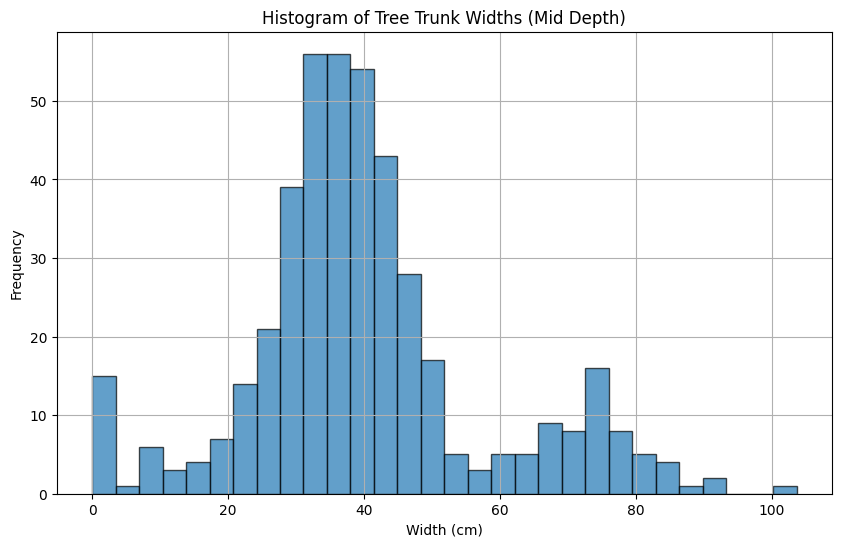

In [41]:
# df_filtered['width_cm_mid']

# Assuming df is your DataFrame and df_filtered is a filtered version of it
# For example, let's filter df to create df_filtered (adjust the condition as needed)
df_filtered = df_filtered[df_filtered['width_cm_mid'].notnull()]

import matplotlib.pyplot as plt

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['width_cm_mid'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Tree Trunk Widths (Mid Depth)')
plt.xlabel('Width (cm)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

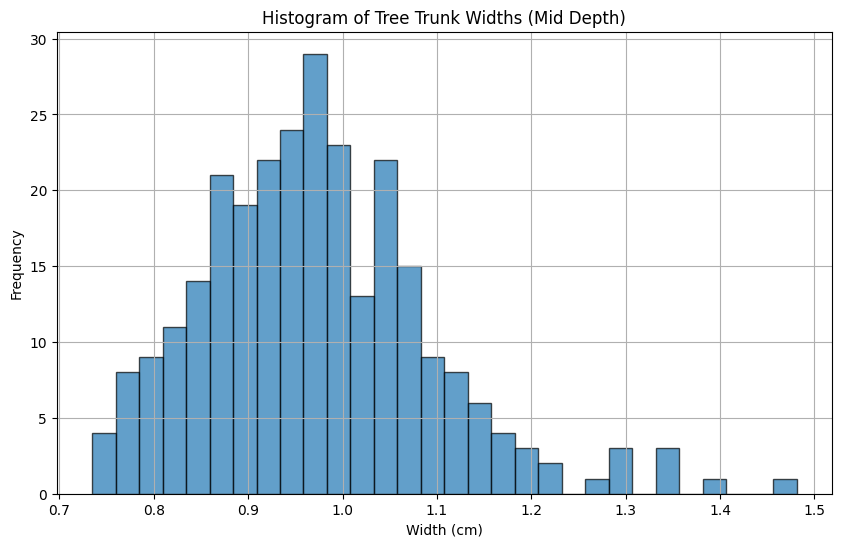

In [42]:
df_ratio = df_filtered[df_filtered['ratio'] < 1.5]
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_ratio['ratio'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Tree Trunk Widths (Mid Depth)')
plt.xlabel('Width (cm)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [43]:
df_ratio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275 entries, 2 to 465
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tree_id            275 non-null    int64  
 1   json_name          275 non-null    object 
 2   frame_number       275 non-null    object 
 3   number_of_trees    275 non-null    int64  
 4   tree_trunk_number  275 non-null    int64  
 5   width_units        275 non-null    float64
 6   width_cm           275 non-null    float64
 7   width_cm_mid       275 non-null    float64
 8   ratio              275 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 21.5+ KB
